In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
import nltk,re
from tqdm import tqdm

In [5]:
data=pd.read_csv('/content/sexism_final_1.csv', encoding='latin-1') # or 'cp1252', 'ISO-8859-1'
print(data.head())

                                                text  target
0  MENTION3481 i didn't even know random was an o...       0
1                   Bottom two should've gone!  #mkr       0
2  MENTION3111 MENTION3424 ladyboner deserves so ...       0
3  She shall now be known as Sourpuss #MKR #KatAn...       0
4  Tarah W threw a bunch of women under the bus s...       0


In [7]:
data.isnull().sum()


,0
text,5
target,0


In [ ]:
data.shape

(13471, 2)

In [8]:
data=data.dropna(axis=0)

In [9]:
data.isnull().sum()

,0
text,0
target,0


In [10]:
data.shape

(20603, 2)

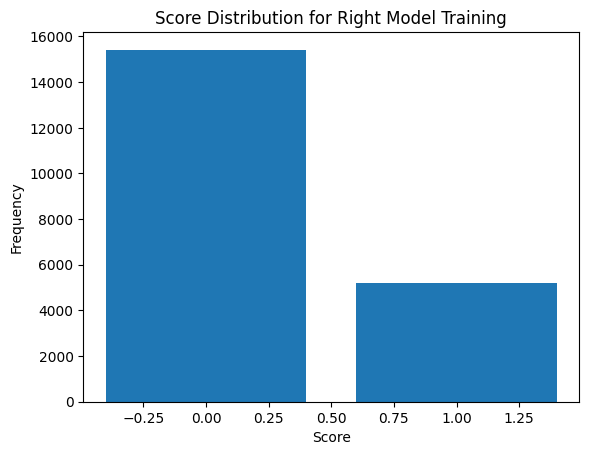

In [12]:
score_counts = data['target'].value_counts()

plt.bar(score_counts.index, score_counts.values)

plt.title('Score Distribution for Right Model Training')
plt.xlabel('Score')
plt.ylabel('Frequency')


plt.show()


In [13]:
score_counts = data['target'].value_counts()
print(score_counts)

target
0    15420
1     5183
Name: count, dtype: int64


In [14]:
data.reset_index(drop=True, inplace=True)  # Reset index if necessary

In [15]:
print(data.head())

                                                text  target
0  MENTION3481 i didn't even know random was an o...       0
1                   Bottom two should've gone!  #mkr       0
2  MENTION3111 MENTION3424 ladyboner deserves so ...       0
3  She shall now be known as Sourpuss #MKR #KatAn...       0
4  Tarah W threw a bunch of women under the bus s...       0


In [18]:
from nltk.stem import WordNetLemmatizer
lm=WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [20]:
corpus =[]
for i in tqdm(range(0,len(data))):
  review = re.sub('[^a-zA-Z]', ' ',data['text'][i])
  review = review.lower()
  review = review.split()

  review = [lm.lemmatize(word) for word in review]
  review = ' '.join(review)
  corpus.append(review)

[[i,j,k] for i,j,k in zip(list(map(len,corpus)),corpus, data['text']) if i<1]


100%|██████████| 20603/20603 [00:06<00:00, 3372.55it/s]


[]

In [ ]:
corpus

['product arrived labeled a jumbo salted peanut the peanut were actually small sized unsalted not sure if this wa an error or if the vendor intended to represent the product a jumbo',
 'this is a confection that ha been around a few century it is a light pillowy citrus gelatin with nut in this case filbert and it is cut into tiny square and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the lion the witch and the wardrobe this is the treat that seduces edmund into selling out his brother and sister to the witch',
 'if you are looking for the secret ingredient in robitussin i believe i have found it i got this in addition to the root beer extract i ordered which wa good and made some cherry soda the flavor is very medicinal',
 'i got a wild hair for taffy and ordered this five pound bag the taffy wa all very enjoyable with many flavor waterm

In [21]:
from nltk import sent_tokenize
from gensim.utils import simple_preprocess

In [22]:
words = []
for sent in tqdm(corpus):
  sent_token=sent_tokenize(sent)
  for sent in sent_token:
    words.append(simple_preprocess(sent))



100%|██████████| 20603/20603 [00:00<00:00, 28409.61it/s]


In [23]:
model = gensim.models.Word2Vec(words)

In [24]:
model.corpus_count

20603

In [ ]:
model.epochs

5

In [25]:
model.wv.similar_by_word('good')

[('who', 0.9487590193748474),
 ('right', 0.9450545310974121),
 ('person', 0.9408412575721741),
 ('him', 0.940211296081543),
 ('every', 0.9358688592910767),
 ('very', 0.9347122311592102),
 ('place', 0.9321272373199463),
 ('only', 0.9316414594650269),
 ('always', 0.927099347114563),
 ('old', 0.9258525371551514)]

In [26]:
def avg_word2vec(doc):
  return np.mean([model.wv[word] for word in doc if word in model.wv.index_to_key],axis=0)

In [27]:
x=[]
for i in tqdm(range(len(words))):
  try:
    x.append(avg_word2vec(words[i]))
  except RuntimeError:
    print("Empty value at",i)


 33%|███▎      | 6824/20603 [00:04<00:06, 2143.15it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 20603/20603 [00:22<00:00, 897.36it/s]


In [28]:
# Filter out invalid entries (e.g., NaN or None)
x_cleaned = [vec for vec in x if vec is not None and not np.isnan(vec).any()]

print(f"Original length: {len(x)}, Cleaned length: {len(x_cleaned)}")


Original length: 20603, Cleaned length: 20599


In [29]:
x=x_cleaned

In [31]:
y=data['target']
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [32]:
data2 = []
for i in tqdm(range(0, len(x))):
    data2.append(x[i].reshape(1, -1))


df = pd.DataFrame(np.vstack(data2))


100%|██████████| 20599/20599 [00:00<00:00, 844435.99it/s]


In [33]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.393084,-0.126042,-0.322748,0.484540,0.065216,-0.431443,0.412858,0.329393,-0.646010,0.094922,...,0.433070,0.427624,0.581805,0.034335,0.137652,0.611036,0.556531,-0.185077,-0.070177,-0.182872
1,-0.365993,-0.071828,-0.229684,0.197488,0.119704,-0.610226,0.528658,0.270252,-0.556443,-0.168766,...,0.526832,0.514947,0.235331,0.206188,0.056610,0.497135,0.115648,-0.531162,-0.119247,0.059403
2,-0.464330,-0.103862,-0.500355,0.332448,0.125763,-0.596820,0.432005,0.077330,-0.379234,0.328696,...,0.511582,0.369096,0.697503,0.102032,-0.184482,0.524446,0.425037,-0.549526,0.198998,-0.030094
3,-0.709718,-0.437495,-0.600905,0.409687,0.005509,-0.714920,0.557584,0.286261,-0.662805,-0.111992,...,0.759221,0.397690,0.645382,0.227471,-0.193138,0.366627,0.690330,-0.056930,-0.138597,0.088367
4,-0.399278,-0.125295,-0.439569,0.426724,0.049338,-0.784059,0.408309,0.158398,-0.653538,-0.072856,...,0.518949,0.457262,0.420304,0.268925,-0.169379,0.478927,0.373394,-0.506342,-0.156405,0.156971


In [34]:
df['output']=y

In [35]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,output
0,-0.393084,-0.126042,-0.322748,0.484540,0.065216,-0.431443,0.412858,0.329393,-0.646010,0.094922,...,0.427624,0.581805,0.034335,0.137652,0.611036,0.556531,-0.185077,-0.070177,-0.182872,0
1,-0.365993,-0.071828,-0.229684,0.197488,0.119704,-0.610226,0.528658,0.270252,-0.556443,-0.168766,...,0.514947,0.235331,0.206188,0.056610,0.497135,0.115648,-0.531162,-0.119247,0.059403,0
2,-0.464330,-0.103862,-0.500355,0.332448,0.125763,-0.596820,0.432005,0.077330,-0.379234,0.328696,...,0.369096,0.697503,0.102032,-0.184482,0.524446,0.425037,-0.549526,0.198998,-0.030094,0
3,-0.709718,-0.437495,-0.600905,0.409687,0.005509,-0.714920,0.557584,0.286261,-0.662805,-0.111992,...,0.397690,0.645382,0.227471,-0.193138,0.366627,0.690330,-0.056930,-0.138597,0.088367,0
4,-0.399278,-0.125295,-0.439569,0.426724,0.049338,-0.784059,0.408309,0.158398,-0.653538,-0.072856,...,0.457262,0.420304,0.268925,-0.169379,0.478927,0.373394,-0.506342,-0.156405,0.156971,0


In [36]:
df.dropna(inplace=True)

In [37]:
df.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
...,...
96,0
97,0
98,0
99,0


In [38]:
x=df.drop('output',axis=1)
y=df['output']

In [39]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

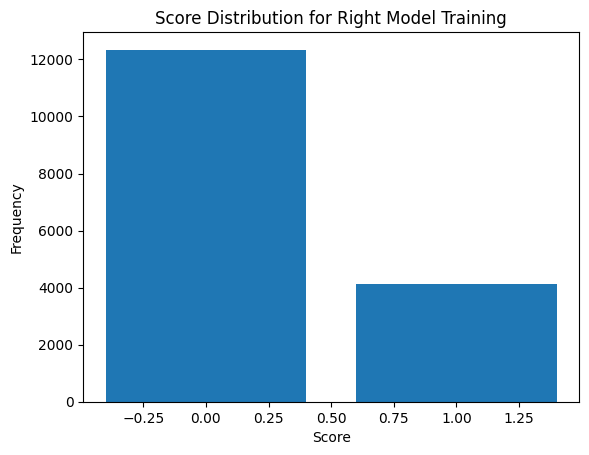

In [40]:
score_counts = y_train.value_counts()

plt.bar(score_counts.index, score_counts.values)

plt.title('Score Distribution for Right Model Training')
plt.xlabel('Score')
plt.ylabel('Frequency')


plt.show()


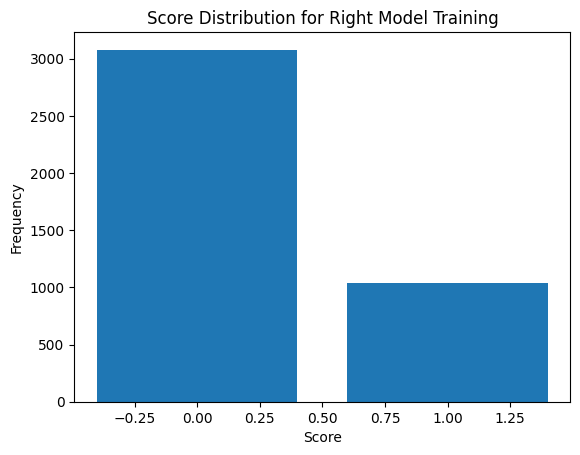

In [41]:
score_counts = y_test.value_counts()

plt.bar(score_counts.index, score_counts.values)

plt.title('Score Distribution for Right Model Training')
plt.xlabel('Score')
plt.ylabel('Frequency')


plt.show()

In [42]:
from sklearn.ensemble import RandomForestClassifier
RF=RandomForestClassifier()
RF.fit(x_train,y_train)
y_pred=RF.predict(x_test)

In [43]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7405339805825243
              precision    recall  f1-score   support

           0       0.77      0.93      0.84      3079
           1       0.47      0.19      0.27      1041

    accuracy                           0.74      4120
   macro avg       0.62      0.56      0.56      4120
weighted avg       0.70      0.74      0.70      4120



In [45]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(x_train, y_train)
y_pred = xg.predict(x_test)


In [46]:
from sklearn.metrics import accuracy_score, classification_report
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.7233009708737864
              precision    recall  f1-score   support

           0       0.77      0.89      0.83      3079
           1       0.41      0.23      0.30      1041

    accuracy                           0.72      4120
   macro avg       0.59      0.56      0.56      4120
weighted avg       0.68      0.72      0.69      4120



In [49]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(max_iter=1000)
LR.fit(x_train, y_train)
y_pred = LR.predict(x_test)

In [50]:
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.749757281553398
              precision    recall  f1-score   support

           0       0.77      0.94      0.85      3079
           1       0.51      0.17      0.26      1041

    accuracy                           0.75      4120
   macro avg       0.64      0.56      0.55      4120
weighted avg       0.71      0.75      0.70      4120



In [56]:
test= 'Womwn dont belong in politics'

In [57]:
words2 = []

# Tokenize the text into sentences
sent_token = sent_tokenize(test)

# Process each sentence
for sent in tqdm(sent_token):
    words2.append(simple_preprocess(sent))

print(words2)

100%|██████████| 1/1 [00:00<00:00, 1290.16it/s]

[['womwn', 'dont', 'belong', 'in', 'politics']]


In [58]:
x2 = []
for i in tqdm(range(len(words2))):
    if not words2[i]:  # Check if the input is empty
        print(f"Empty value at {i}")
        continue
    x2.append(avg_word2vec(words2[i]))

100%|██████████| 1/1 [00:00<00:00, 395.47it/s]


In [59]:
y_pred2=LR.predict(x2)
if y_pred2==0:
  print('Not Sexism')
else:
  print('Sexism')

Not Sexism
